Name - Sarthak Bhatore

Email - Sarthakbhatore637@gmil.com

## Approach


In our approach to solving this problem, we have chosen a customized U-Net architecture, a popular choice for image segmentation tasks. Let's delve into the key components and technical details:

**1. U-Net Architecture:**

The U-Net architecture is a convolutional neural network (CNN) known for its effectiveness in semantic segmentation. It consists of an encoder and a decoder, forming a U-shaped network.

**2. Preprocessing**

 I've established a robust image preprocessing pipeline to ready both color (RGB) and black-and-white (BW) images for neural network training. Within this pipeline, RGB images undergo conversion to tf.uint8, uniform resizing to 128x128 pixels, and subsequent normalization to a range of [0, 1]. For BW images, similar resizing occurs, followed by thresholding to generate binary masks. Processed data is stored in images_data and masks_data, then converted to TensorFlow tensors for seamless integration into model training. This meticulous preprocessing ensures standardized, compatible data, setting the foundation for effective neural network training in my project.

**3. Encoder (Downsampler):**

For our encoder, we employ a MobileNetV2 model, initialized with weights pre-trained on a large dataset. The input size for this encoder is set to 128x128 pixels with three color channels.

**4. Decoder (Upsampler):**

The decoder takes the feature maps produced by the encoder and performs the task of upsampling. It gradually increases the spatial resolution of the feature maps to generate a segmentation mask that matches the input image size.
For our decoder, we leverage the upsample block inspired by the pix2pix model. This block employs a combination of upsampling layers and skip connections, allowing the network to capture fine-grained details and spatial information.

**5. Training Process:**

During the training process, we train the model for 40 epochs

For validation, we perform validation on the test dataset
The training process involves optimizing the model's parameters using backpropagation and an appropriate optimizer ( Adam) to minimize the loss.


                      ================== Model  Architecture ==================


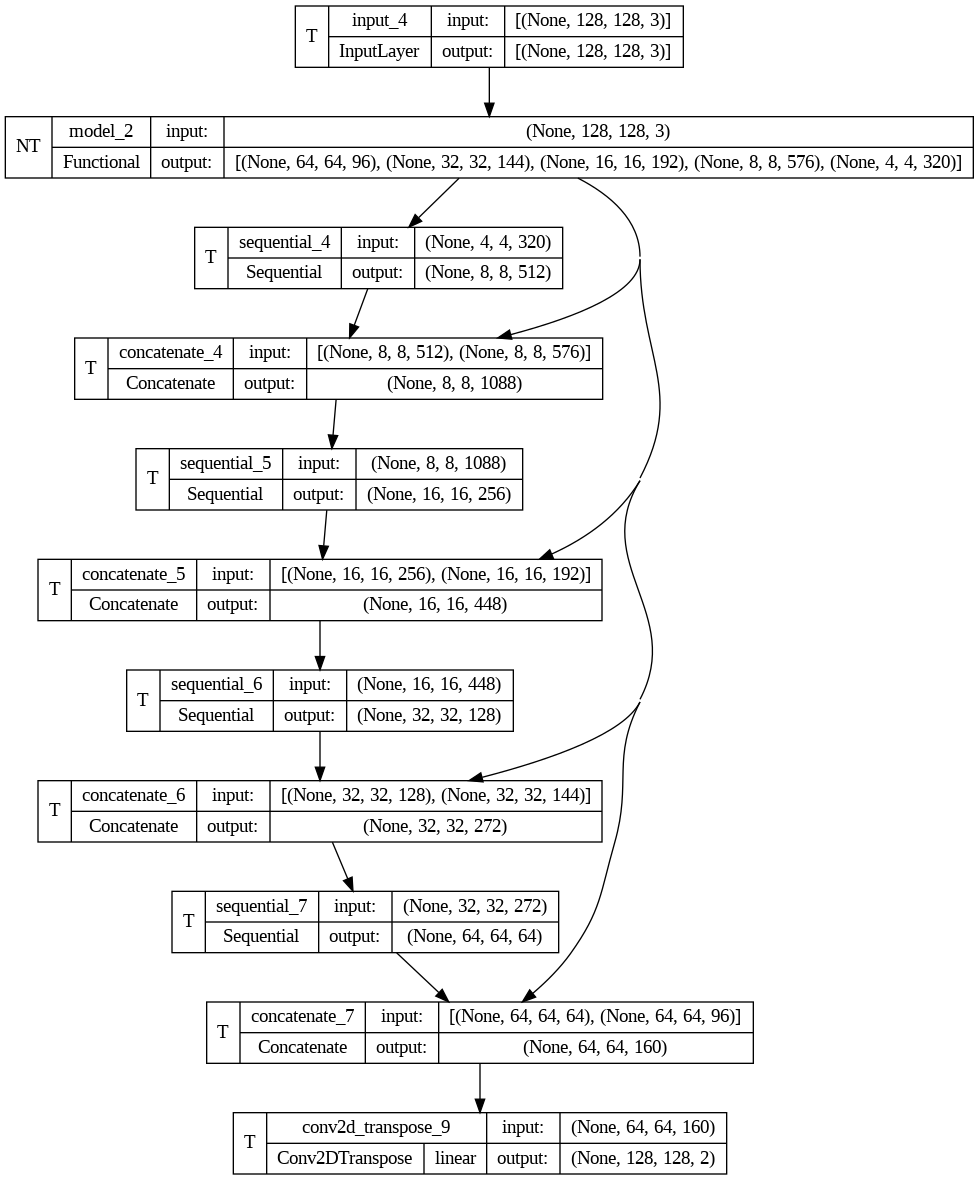

# Code

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-ftw0lsgo
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-ftw0lsgo
  Resolved https://github.com/tensorflow/examples.git to commit 2741d0f2a345ef52e0de1d498de732f5dacbf2f0
  Preparing metadata (setup.py) ... done


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import cv2
import os
import numpy as np
import zipfile



In [ ]:


zip_file_path = '/content/trainset-20230914T105642Z-001.zip'  # Update with your actual file path

# Specify the directory where you want to extract the data
extracted_dir = '/content/'  # Update with your desired extraction directory

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)


In [ ]:
input_folder = '/content/trainset/train-volume'
output_folder = '/content/trainset/train-labels'

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images
input_images = load_images_from_folder(input_folder)
output_images = load_images_from_folder(output_folder)
input_images = np.array(input_images)
output_images = np.array(output_images)

# Print the shape of the loaded data to verify
print("Input images shape:", input_images.shape)
print("Output images shape:", output_images.shape)

Input images shape: (30, 512, 512, 3)
Output images shape: (30, 512, 512, 3)


In [ ]:
colored_images=input_images
colored_images = colored_images / 255.0

# Expand dimensions of label images for compatibility with model
label_images = np.expand_dims(input_images, axis=-1)

In [ ]:


# Split the dataset into training, validation, and test sets
train_images, val_images, train_masks, val_masks = train_test_split(
    input_images, output_images, test_size=0.2, random_state=42
)
test_images, val_images, test_masks, val_masks = train_test_split(
    val_images, val_masks, test_size=0.5, random_state=42
)

In [ ]:
train_colored, val_colored, train_labels, val_labels = train_test_split(
    colored_images, label_images, test_size=0.2, random_state=42
)

In [ ]:

# Load a sample image from your dataset
sample_image_path = '/content/trainset/train-volume/train-volume_0.tif'  # Replace with the actual path
sample_image = cv2.imread(sample_image_path)

# Get image dimensions and color channels
height, width, channels = sample_image.shape

In [ ]:


rgb_images_dir = '/content/trainset/train-volume'
bw_images_dir = '/content/trainset/train-labels'

images_data = []
masks_data = []



def preprocess_rgb_image(image):
    image = tf.image.convert_image_dtype(image, tf.uint8)
    # Resizing
    image = tf.image.resize(image, (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Normalizing the image to the range [0, 1]
    image = tf.cast(image, tf.float32) / 255.0

    return image

def preprocess_bw_image(image):


    image = tf.image.convert_image_dtype(image, tf.uint8)



    image = tf.image.resize(image, (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)


    # Binarizing the image (thresholding)
    image = tf.where(image >= 128, 1, 0)
    # print(type(image))
    return image


for rgb_filename in os.listdir(rgb_images_dir):
    if rgb_filename.endswith('.tif'):

        rgb_image_path = os.path.join(rgb_images_dir, rgb_filename)
        rgb_image = cv2.imread(rgb_image_path)
        rgb_image = tf.convert_to_tensor(rgb_image)
        rgb_image = preprocess_rgb_image(rgb_image)
        # print(type(rgb_image))
        label_filename = rgb_filename.replace('volume', 'labels')
        bw_image_path = os.path.join(bw_images_dir, label_filename)


        bw_image = cv2.imread(bw_image_path,cv2.IMREAD_GRAYSCALE)
        bw_image = bw_image[:, :, np.newaxis]
        bw_image = tf.convert_to_tensor(bw_image)
        bw_mask = preprocess_bw_image(bw_image)
        images_data.append(rgb_image)
        masks_data.append(bw_mask)
images_data = tf.convert_to_tensor(images_data)
masks_data = tf.convert_to_tensor(masks_data)
print(type(images_data))


<class 'tensorflow.python.framework.ops.EagerTensor'>


# The following class performs a simple augmentation by randomly-flipping an image.



In [ ]:


dataset = tf.data.Dataset.from_tensor_slices((images_data, masks_data))


class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # Both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

# Defining the batch size and buffer size
BATCH_SIZE = 1
BUFFER_SIZE = len(images_data)


train_size = int(0.8 * len(images_data))
test_size = len(images_data) - train_size


train_batches = (
    dataset
    .take(train_size)
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = (
    dataset
    .skip(train_size)
    .take(test_size)
    .batch(BATCH_SIZE)
)


In [ ]:
print(train_size)

24


In [ ]:
train_batches_size = tf.data.experimental.cardinality(train_batches).numpy()
print(train_batches_size)

-1


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [ ]:
dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.int32, name=None))>

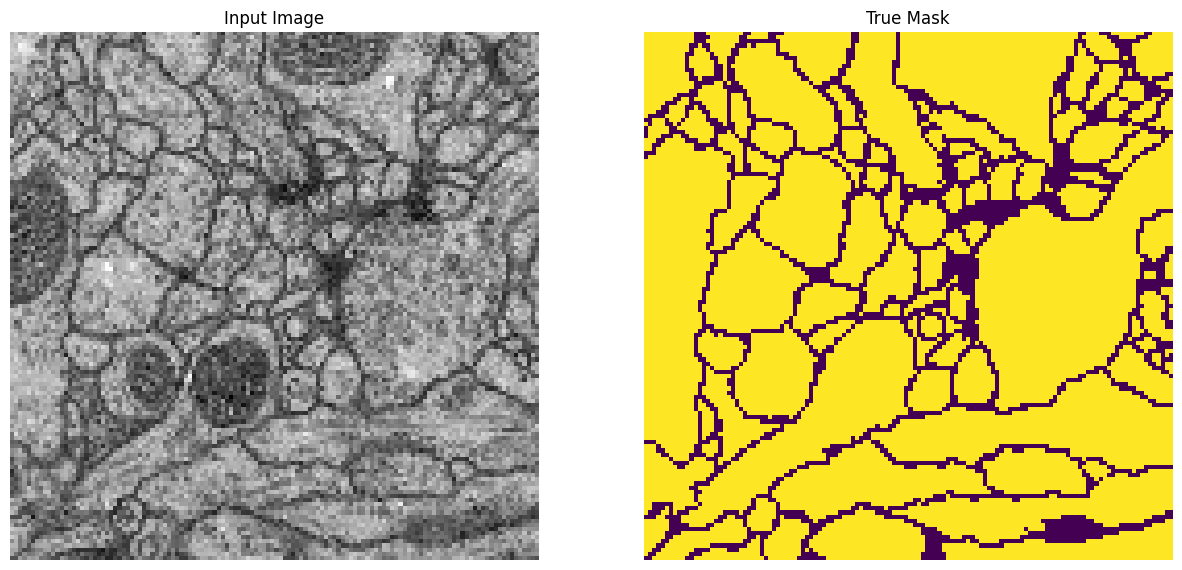

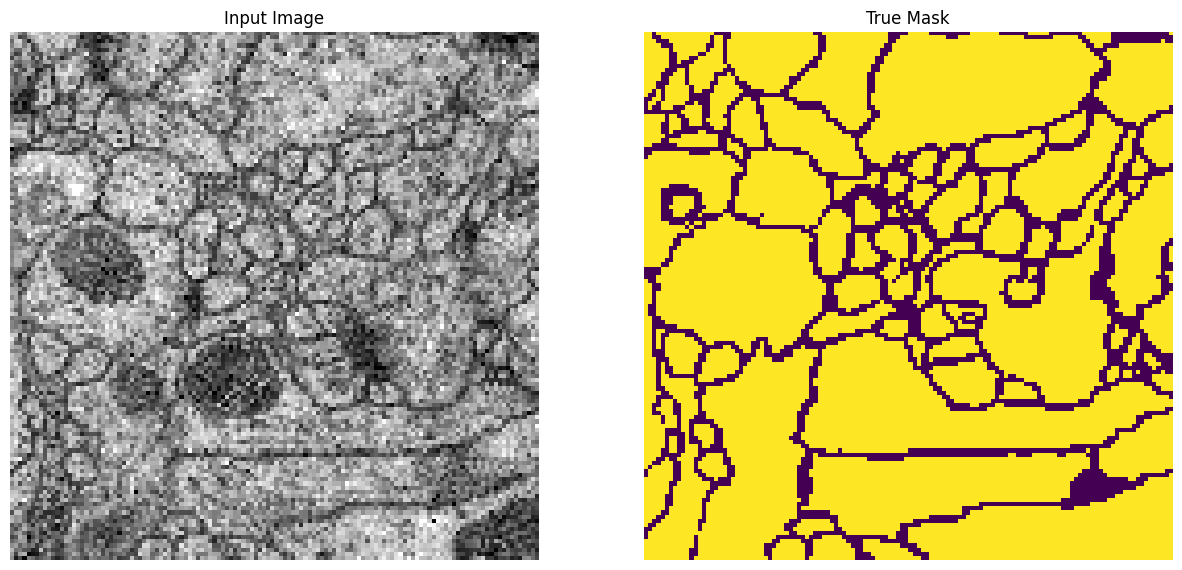

In [ ]:
import matplotlib.pyplot as plt
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Using the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Creating the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],run_eagerly=True)

In [ ]:
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           [(None, 64, 64, 96)  1841984     ['input_4[0][0]']                
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

In [ ]:
print(BATCH_SIZE)

1


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
TRAIN_LENGTH=train_size

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


1/1 [==============================] - 0s 234ms/step


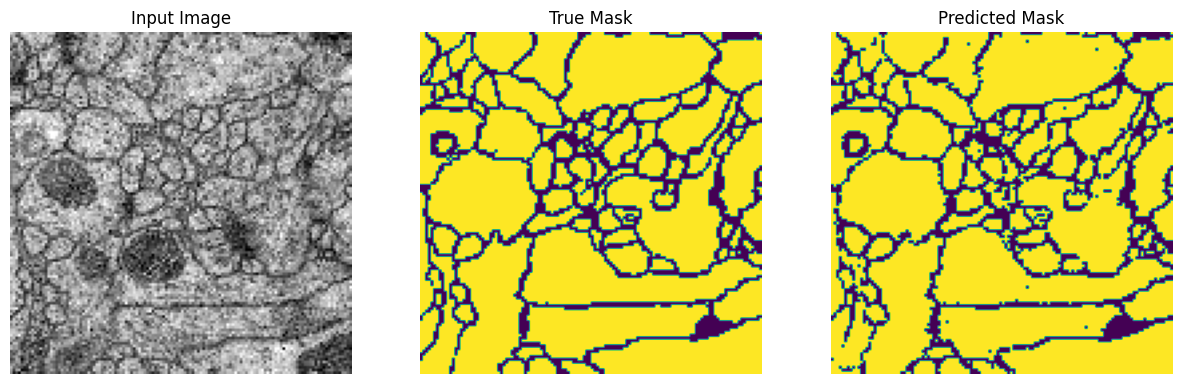


Sample Prediction after epoch 40

24/24 [==============================] - 16s 683ms/step - loss: 0.1387 - accuracy: 0.9432 - val_loss: 0.4106 - val_accuracy: 0.8498


In [ ]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 4

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

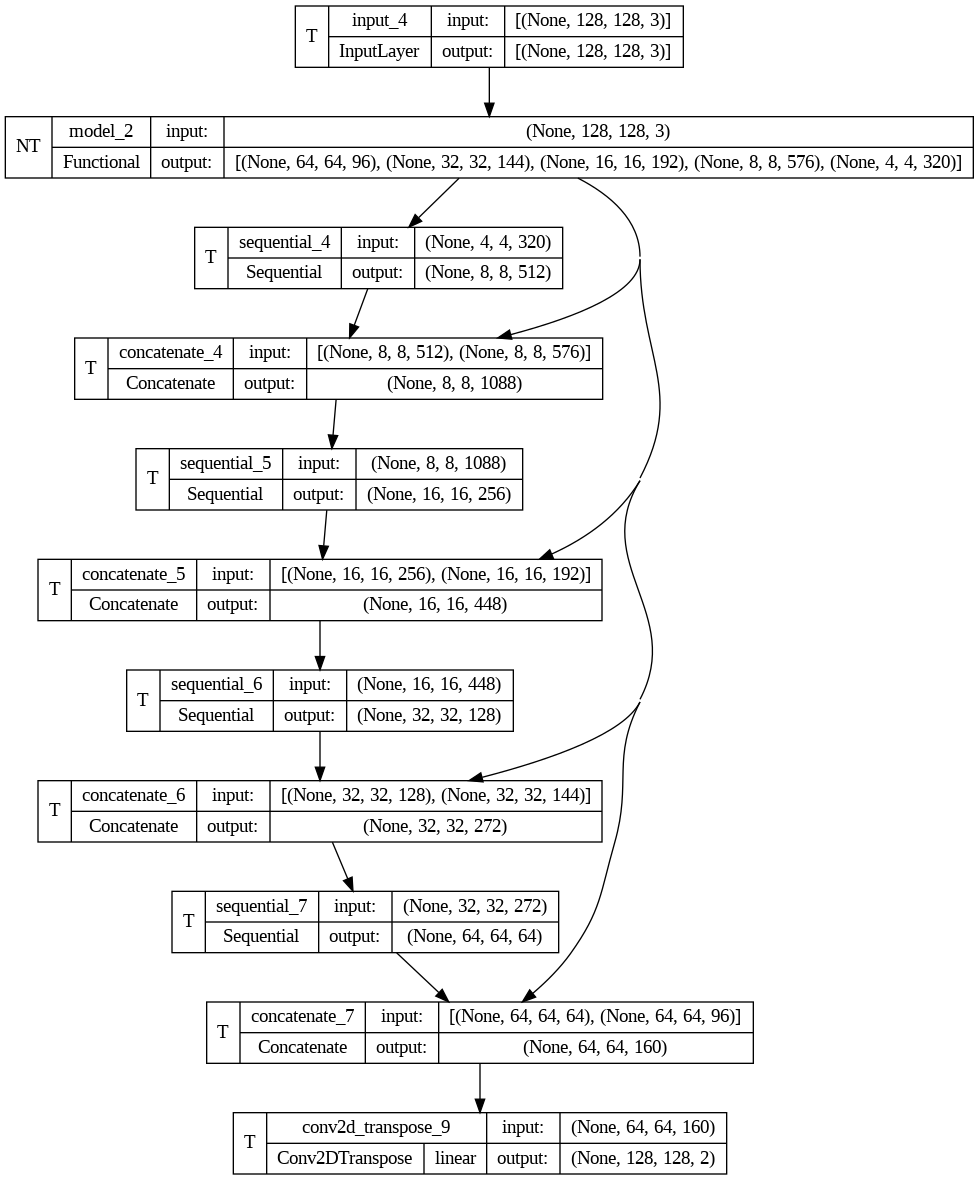

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

In [ ]:
model_save_path = "/contents/semantic_segmentation_model_epochs40_2023-09-17.h5"

tf.keras.models.save_model(model, model_save_path)

In [ ]:
# import cv2
# import tensorflow as tf
# import numpy as np
# from matplotlib import pyplot as plt

# model_path = '/contents/semantic_segmentation_model_epochs40_2023-09-17.h5'  # Update with the actual path
# model = tf.keras.models.load_model(model_path)


# input_image_path = '/content/trainset/train-volume/train-volume_11.tif'  # Replace with the actual path

# input_image = cv2.imread(input_image_path)

# image = tf.image.convert_image_dtype(input_image, tf.uint8)

# image = tf.image.resize(image, (128, 128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

# input_image = tf.cast(image, tf.float32) / 255.0

# # Make a prediction
# input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
# prediction = model.predict(input_image)
# pred_mask = tf.math.argmax(prediction, axis=-1)
# predicted_mask = (pred_mask[..., tf.newaxis])[0]


# # Display the input image and predicted mask
# plt.figure(figsize=(15, 15))

# plt.subplot(121)
# plt.title('Input Image')
# plt.imshow(input_image[0])
# plt.axis('off')

# plt.subplot(122)
# plt.title('Predicted Mask')
# plt.imshow(predicted_mask)
# plt.axis('off')

# plt.show()
